# Tutorial 21: Temperature Accelerated Dynamics in 2D - Part II
Yikai Yin, Yifan Wang and Wei Cai

**2019-07-11**

## Initialization


**1. This notebook uses the following extensions, please set them up in nbextensions before using this notebook**
* Table of Content (2)

<sub>Instructions for nbextension installation is in [Tutorial 01 1.2.2.2](Tutorial%2001%20-%20Introduction%20to%20MD%2B%2B.ipynb)</sub>

**2. OVITO for visualizing configurations**

<sub>Instructions for OVITO installation in [Tutorial 08](Tutorial%2008%20-%20Introduction%20to%20OVITO.ipynb) </sub>

**3. If you have not set the environment variables, please add the following 4 lines into `~/.bashrc`, and reboot Ubuntu to setup the environment variables**

These environmental variables specifies the MD++ root directory, the MD++ compiling system, and name of the MD++ executable, respectively.

**4. Check if environmental variables are set. Change current working directory into the MD++ root folder**

In [ ]:
import os

envvar_test = True
envvars = ['MDPLUS_DIR', 'MDPLUS_EXE', 'MDPLUS_SYS', 'OVITOS_BIN']
for envvar in envvars:
    if envvar not in os.environ.keys():
        print('Environment variable "'+envvar+'" not set')
        envvar_test = False
    else:
        print('Environment variable "'+envvar+'" set to '+os.environ[envvar])

if not envvar_test:
    raise OSError

mdpp_dir = os.environ['MDPLUS_DIR']
os.chdir(mdpp_dir)

<div class="alert alert-block alert-info">
<b></b> In this tutorial, we are going to develop a complete Temperature Accelerated Dynamics (TAD) algorithm and use it to find the low temperature behavior of a particle with the 2D langevin dynamics described in Tutorial 20.
</div>

According to the transition state theory (TST), the transition rate can be calculated as follows:

<font size="3.5">
$$
  k = \tilde{\nu}\cdot{\rm e}^{-\frac{E_{\rm b}}{k_BT}}
$$
</font>

Using the above equation, we can extrapolate each time of escaping a basin observed at $T_{high}$ to obtain a corresponding escape time at $T_{low}$. This extrapolation, which does not require knowing the preexponential factor ($\tilde{\nu}$), can be illustrated graphically in an Arrhenius-style plot ($\ln(1/t)$ vs. $1/T$). The time for each event seen at $T_{high}$ extrapolated to $T_{low}$ is:

<font size="3.5">
$$
  t_{low} = t_{high}\cdot{\rm e}^{{E_{\rm b}\big({\frac{1}{k_BT_{low}}}-\frac{1}{k_BT_{high}}}\big)}
$$
</font>

For one escape event $T_{low}$, we can define a time ($t_{high,stop}$) at which the high temperature simulation can be stopped according to the following equation:

<font size="3.5">
$$
  t_{high,stop} = \frac{1}{{\nu_{min}^{*}}}\cdot({\nu_{min}^{*}}\cdot t_{low,short})^{T_{low}/T_{high}}
$$
</font>

where $\nu_{min}^{*}$ is an assumption of the minimum frequency prefactor for the stopping criterion, $t_{low,short}$ is the shortest transition time at $T_{low}$.

$\textbf{Reference}$: Mads R. Sørensen and Arthur F. Voter. Temperature-accelerated dynamics for simulation of infrequent events. J. Chem. Phys. 112, 9599 (2000)

## Define functions and parameters
Let's define the following functions and parameters that are used in the TAD algorithm.


In [ ]:
# Define a potential field and its corresponding force fields
U  = lambda x,y: np.cos(14.5*x-0.3)*np.sin(12*y) + (x + 0.2)*x + (y + 0.2)*y
fx  = lambda x,y: -(-14.5*np.sin(14.5*x-0.3)*np.sin(12*y)+2*x+0.2)
fy = lambda x,y: -(12*np.cos(14.5*x)*np.cos(12*y)+2*y+0.2)

In [ ]:
import numpy as np
# Plot a potential field in 2d
# lo: lower boundary of x, y
# hi: high boundary of x, y
# delta: mesh size
lo = -1;hi = 1;delta = 0.02
X, Y = np.meshgrid(np.arange(lo, hi+delta, delta), np.arange(lo, hi+delta, delta))
U_plot = U(X,Y)

In [ ]:
# Steepest Descent Relaxation

# Input:
# x0: initial position [x,y]

# Output:
# xs: final position, xsav: trajectory from x0 to xs

def steepest_descent(U, fx, fy, x0, stepsize=0.001, dr_max=0.01, ftol = 1e-10, maxiter=1000, savefreq=10):
    xsav=np.zeros([maxiter//savefreq,2])
    xsav[0,:]=x0
    
    xs = np.array(x0)
    # steepest descent from x0
    for iter in range(maxiter):
        E = U(xs[0],xs[1])
        Fx = fx(xs[0],xs[1])
        Fy = fy(xs[0],xs[1])
        F = np.array([Fx, Fy])
        
        dr = F * stepsize
        if np.linalg.norm(dr) > dr_max:
            dr = dr / np.linalg.norm(dr) * dr_max
        xs += dr
        
        if np.mod(iter,savefreq)==0:
            xsav[iter//savefreq,:] = xs;
            
        if np.linalg.norm(F) < ftol:
            break
            
    xsav = xsav[0:iter//savefreq+1]

    return xs, xsav

In [ ]:
# Integrate the Langevin equation of motion

# Input:
# x0 initial position vector before integrating
# v0 initial velocity vector before integrating

# Output:
# x,y: displacements, v_x,v_y: velocities, t: time

def int_langevin_2d(T, gamma, kB, m, massconvert,dt, totalsteps, x0,v0):

    x = np.zeros(totalsteps+1)
    v_x = np.zeros(totalsteps+1)
    t = np.arange(totalsteps+1)*dt

    y = np.zeros(totalsteps+1)
    v_y = np.zeros(totalsteps+1)
    t = np.arange(totalsteps+1)*dt

    # assign the initial position 
    x[0] = x0[0]
    y[0] = x0[1]
    v_x[0] = v0[0]
    v_y[0] = v0[1]

    # pre-generate all random numbers with normal distribution
    xi_x = np.random.normal(size=totalsteps) 
    xi_y = np.random.normal(size=totalsteps) 

    factor_ext_force = dt/(m*massconvert)
    factor_rnd_force = np.sqrt(2*kB*T*gamma*dt)/(m*massconvert)

    for curstep in range(totalsteps):
        x[curstep+1] = x[curstep] + v_x[curstep]*dt
        v_x[curstep+1] = (1-gamma/(m*massconvert)*dt)*v_x[curstep] + factor_ext_force*fx(x[curstep],y[curstep]) + factor_rnd_force*xi_x[curstep]

        y[curstep+1] = y[curstep] + v_y[curstep]*dt
        v_y[curstep+1] = (1-gamma/(m*massconvert)*dt)*v_y[curstep] + factor_ext_force*fy(x[curstep],y[curstep]) + factor_rnd_force*xi_y[curstep]
    
    return x,y,v_x,v_y,t

In [ ]:
# NEB calculation for Eb between state A and B

# Input:
# rA = [x y]     # position of state A
# rB = [x y]     # position of state B
# Ncopy          # number of copied states in a min energy path chain 

# Output:
# Eb: energy barrier, Epath: Min energy path on chain number

def NEB_calculation(rA, rB, Ncopy,Niter = 1000,reparfreq = 10, stepsize = 0.001):

    alg = 1  # 0: NEB, 1: string method

    ### Specify the start and end point for NEB calculation
    xpath = np.zeros([Ncopy,2])
    xpath[0,:] = rA
    xpath[-1,:] = rB

    for i in range(1, Ncopy-1, 1):
        xpath[i,:] = xpath[0,:]+(xpath[-1,:]-xpath[0,:])*(i-1)/(Ncopy-1)
        xpath[i,1] = xpath[i,1]+(2*np.random.rand()-1)*0.01

    fpath = np.zeros(xpath.shape[0])

    for iter in range(Niter):

        Epath = U(xpath[:,0],xpath[:,1])
        fpath_x = fx(xpath[:,0],xpath[:,1])
        fpath_y = fy(xpath[:,0],xpath[:,1])
        fpath = np.transpose([fpath_x, fpath_y])

        fpath[0,:] = 0 
        fpath[-1,:] = 0
        fpathm = fpath[1:-1,:]

        dx = xpath[2:Ncopy,:]-xpath[0:Ncopy-2,:] # local tangent vector
        dr = np.sqrt(np.sum(dx**2,1))
        dx = dx/np.transpose([dr,dr])

        fpathn = fpathm - dx*np.transpose([np.sum(fpathm*dx,1), np.sum(fpathm*dx,1)])

        if alg == 0:
            #NEB spring force
            xe = xpath[1:Ncopy-1,:]-0.5*(xpath[0:Ncopy-2,:]+xpath[2:Ncopy,:])       
            fpatht = -dx*np.transpose([np.sum(xe*dx,1), np.sum(xe*dx,1)])
            fpath = np.vstack(([0,0],fpathn+fpatht,[0,0]))
        else:
            #string method
            fpath = np.vstack(([0,0],fpathn,[0,0]))

        mf = np.max(np.max(fpath,0),0);
        if mf > 0.5:
            fpath = fpath/mf;

        xpath = xpath + fpath*stepsize

        #reparametrization step (consistent with reparamChain_paralle() in MD++)
        xpath_new = xpath.copy()
        if alg == 1: #string method
            if np.mod(iter,reparfreq) == 0:
                ds = xpath[1:Ncopy,:]-xpath[0:Ncopy-1,:]
                dl = np.hstack((0,np.sqrt(np.sum(ds**2,1))))
                dl0 = dl.sum() / (Ncopy-1)

                for i in range(1, Ncopy-1, 1):
                    new_position = dl0 * i
                    left_index = 0
                    while new_position > dl[left_index+1]:
                        left_index += 1
                        new_position -= dl[left_index]

                    if left_index == Ncopy - 1:
                        left_index = Ncopy - 2
                        right_index = Ncopy - 1
                        new_position += ds[right_index]
                    else:
                        right_index = left_index + 1

                    alpha = new_position / dl[right_index]
                    xpath_new[i,:] = (1-alpha)*xpath[left_index,:] + alpha*xpath[right_index,:]

                xpath = xpath_new.copy()
                
    Eb = np.max(Epath)-Epath[0]
    
    return Eb, Epath

In [ ]:
# Search neighboring states (B,C,D ...) of State A at high temperature

# Input:
# T_high               # the high temperature to run the search
# T_low                # the low temperature of interest
# xA                   # initial metastable state (need to be at an energy minimum)
# nstates              # maximum number of states to search
# nu_min_star          # assumption of the minimum frequency prefactor (stopping criterion)
# Ncopy                # number of copied states in a min energy path (MEP) chain 
# rtol                 # distance torlarance to compare two positions
# t_check              # check state per t_check steps, t_check*dt in ps
# max_iter             # maximum steps for searching each state 
# print_freq           # print state position 
# print_info           # whether to print info, print info = 1 to print# 

# Output:
# x_next               # predicted state after one jump at T_low
# t_lo_min             # predicted time of the first jump at T_low
# x_list               # Store the position of all neighboring states
# t_hi_list            # Store the time consumed to find each state at high temperature
# t_lo_list            # Store the time consumed to find each state at low temperature
# Eb_list              # Store the energy barriers between state A and each neighbor state
# Epath_list           # Store the minimum energy path between state A and each neighbor state

def search_state_highT( T_high, T_low, xA, nstates, nu_min_star = 0, Ncopy = 41, rtol = 0.001, t_check = 1000,
                        max_iter = 3000, print_freq = 100, print_info = 1):
       
    x_list = xA
    t_hi_list = [0]
    t_lo_list = [0]
    Eb_list = [0]
    Epath_list = np.zeros([Ncopy])
    x0 = xA
    v0 = [0,0]
    t_high_stop = np.inf
    stop_search = False
    
    #print(nstates) 
    
    for istate in range(nstates):
        if print_info == 1:
            print('Search for state %d'%(istate+1))
            
        if stop_search:
            break

        for iter_num in range(max_iter):
            traj = int_langevin_2d(T_high, gamma, kB, m, massconvert, dt, t_check, x0,v0)
            x_end = [traj[0][-1], traj[1][-1]]
            v_end = [traj[2][-1], traj[3][-1]]
            x_final, xsav = steepest_descent(U, fx, fy, x_end)
            
            t_high = iter_num*t_check*dt + t_hi_list[-1]
            
            if print_info == 1 and iter_num%print_freq ==0:
                print('  iter %d/%d t_high %g/%g:'%(iter_num+1, max_iter, t_high, t_high_stop), x_final)
                
            if t_high > t_high_stop:
                print ('t_high = %g, t_high_stop = %g, Stop searching'%(t_high,t_high_stop))
                stop_search = True
                break
                
            # check if the new state is different from A

            if np.linalg.norm(xA - x_final, axis=-1) > rtol:
                x0 = xA
                # v0 = v_end
                v0 = [0,0]

                # additional print if you find a different state from A
                if print_info == 1 and iter_num%print_freq !=0:
                    print('  iter %d/%d t_high %g/%g:'%(iter_num+1, max_iter, t_high, t_high_stop), x_final)
            else:
                x0 = x_end
                v0 = v_end

            # check if the new state is already in the list
            if np.all(np.linalg.norm(x_list-x_final, axis=-1) > rtol):          
                x_list = np.vstack((x_list,x_final))
                t_hi_list = np.append(t_hi_list,iter_num*t_check*dt + t_hi_list[-1])

                Eb_final,Epath_final = NEB_calculation(xA, x_final,Ncopy)
                Eb_list =  np.append(Eb_list,Eb_final)  
                Epath_list = np.vstack((Epath_list,Epath_final))
                
                t_lo_list = t_hi_list * np.exp(Eb_list/kB* (1/T_low - 1/T_high))
                
                ind_t_lo_min = np.argmin(t_lo_list[1:])+1
                x_next = x_list[ind_t_lo_min]   
                t_lo_min = t_lo_list[ind_t_lo_min]
                
                if nu_min_star > 0:
                    t_high_stop = 1/nu_min_star * (nu_min_star * np.min(t_lo_list[1:]))**(T_low/T_high)
        
                break

            if print_info == 1 and iter_num == max_iter-1:
                print('No new state found given the max iters')
        
    if print_info == 1:
            print('Position of States (A): \n',x_list)
            print('Time of finding each state (ps):',t_hi_list)
            print('Energy barrier of each state (eV):',Eb_list)
                
    return x_next, t_lo_min, x_list, t_hi_list, t_lo_list, Eb_list, Epath_list

In [ ]:
# Plot the potential metastate states and MEP

# Input:
# x_list         # Store the position of all neighboring states

def plot_MEP(x_list):
    color_list = ['red','blue','green','purple','yellow','magenta','cyan','gray']
    state_list = ['A','B','C','D','E','F','G']

    fig, axs = plt.subplots(1, 2,figsize=(9,4))
    im = axs[0].imshow(U_plot, interpolation='bilinear', cmap=cm.gray,
                   origin='lower', extent=[lo, hi, lo, hi])

    for i in range(len(x_list)):
        axs[0].plot(x_list[i,0], x_list[i,1], 'o',color=color_list[i])
        axs[0].text(x_list[i,0]+0.03, x_list[i,1]+0.03, 'State %s'%(state_list[i]), fontsize=9,color=color_list[i])
        if i > 0:
            axs[1].plot(np.arange(len(Epath_list[i])), Epath_list[i], '.-', linewidth=1, antialiased=True, color=color_list[i])

    axs[0].set_xlabel('x (A)')
    axs[0].set_ylabel('y (A)');
    axs[0].set_title('Metastable states')
    axs[1].set_xlabel('chain number')
    axs[1].set_ylabel('E (eV)');
    axs[1].set_title('Energy profile along MEP')

In [ ]:
# Schematic illustration of the TAD in Arrhenius Plot 
# Mapping the transition rates to low temperature

# Input:
# t_hi_list      # Store the time consumed to find each state at high temperature
# t_lo_list      # Store the time consumed to find each state at low temperature
# Eb_list        # Store the energy barriers between state A and each neighbor state
# T_high         # your high temperature
# T_low          # your high temperature

def plot_Arrhenius(t_hi_list, t_lo_list, Eb_list, T_high, T_low):
    
    color_list = ['red','blue','green','purple','yellow','magenta','cyan','gray']
    
    #t_hi_list = t_list[1:]
    #t_lo_list = t_hi_list * np.exp(Eb_list[1:]/kB* (1/T_low - 1/T_high))

    fig, axs = plt.subplots(1, 1, figsize=(9, 6))
    for i in range(1,len(t_hi_list)):
        axs.plot(np.divide(1,[T_high, T_low]), np.divide(1, [t_hi_list[i], t_lo_list[i]]),'*-',color=color_list[i])

    axs.plot(np.divide(1,[T_high, T_high]), [1e-30, 1],'--',color='red')
    axs.plot(np.divide(1,[T_low, T_low]), [1e-30, 1],'--',color='black')
    axs.set_xlabel('1/T (1/K)')
    axs.set_ylabel('Transition rate (1/ps)');
    axs.set_title('Arrhenius plot')
    axs.set_yscale('log')
    axs.set_xlim((0, 1/T_low + 0.0005))

    axs.text(1/T_high+0.0001, 1e-23, '$1/T_{high}$', fontsize=12,color='red')
    axs.text(1/T_low-0.0004, 1e-3, '$1/T_{low}$', fontsize=12,color='black')

    plt.show()
    

## Example program to predict  jump events at low temperature 

The following program shows an example of searching neighboring states of a metastable state A at high temperature. The energy barrier and MEP between state A and each of its neighboring state is plotted. The Arrhenius plot for mapping high-temperature transition rates to low-temperature transition rates is shown at the end.

In [ ]:
# Main program

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

x_i = [-0.6, -0.6]        # Initial position of the particle (in Angstrom)

T_high = 3500              # High Temperature for TAD (in K)
T_low = 250                # Low Temperature of interest, in K

gamma = 100                # Friction coefficient (eV/A^2 * ps)
kB = 8.6173324e-5          # Boltzmann constant (in eV/K)
m  = 1e4                   # Mass (in g/mol)
dt = 0.0001                # Time step (ps)

nstates = 4                # maximum number of states to search
nu_min_star = 1e-1         # assumption of the minimum frequency prefactor (stopping criterion)

# mass convertion factor from (g/mol) to (eV/(A/ps)^2)
massconvert = 1e-3/6.0221367e23/1.6021772e-19/1e20*1e24 

xA, x_itoA = steepest_descent(U, fx, fy, x_i);  # Position of metastable State A

# Search neighboring states 
x_next, t_lo_min, x_list, t_hi_list, t_lo_list, Eb_list, Epath_list = search_state_highT(T_high, T_low, xA, nstates, nu_min_star)

In [ ]:
# Plot the potential metastate states and MEP
plot_MEP(x_list)

# Map to low temperature in an Arrhenius plot
plot_Arrhenius(t_hi_list, t_lo_list, Eb_list, T_high, T_low)

Among all the neighboring states of the initial state (A), the state with the highest predicted transition rate at low temperature is treated as the next state that the particle jump into. This new state is refered as the new State A. 

The following program shows how to find the state after the first jump and search the neighboring states of the new state for the second jump.

In [ ]:
# Find the new state A after the first jump at low temperature
xA_new = x_next
       
# Search neighboring states 
x_next, t_lo_min, x_list, t_hi_list, t_lo_list, Eb_list, Epath_list = search_state_highT(T_high, T_low, xA_new, nstates, nu_min_star)

# Plot the potential metastate states and MEP
plot_MEP(x_list)

# Map to low temperature in an Arrhenius plot
plot_Arrhenius(t_hi_list, t_lo_list, Eb_list, T_high, T_low)

<font size=+1> **Exercise 1** </font>

Pick another initial state whose coordinates satisfy $x \in [-1, 1]$ and $y \in [-1, 1]$, then perform a steepest descent relaxation to reach State A. Write a program that can be used to predict $\textbf{6 movements}$ (jump events) $\textbf{at low temperature}$ (300K) starting from your State A by running the simulation at high temperature (picked by yourself, e.g. 3500K). You can use the functions and codes provided above. 

In [ ]:
# Your code here


<font size=+1> **Exercise 2** </font>

Plot the positions (trajectories) of each predicted movement at low temperature on the 2d potential field.


In [ ]:
# Your code here


<font size=+1> **Exercise 3** </font>

Plot the displacements (starting from State A) of the 6 movements as a function of time at low temperature. You results should look in a similar format as the following (each jump event is represented by one color): 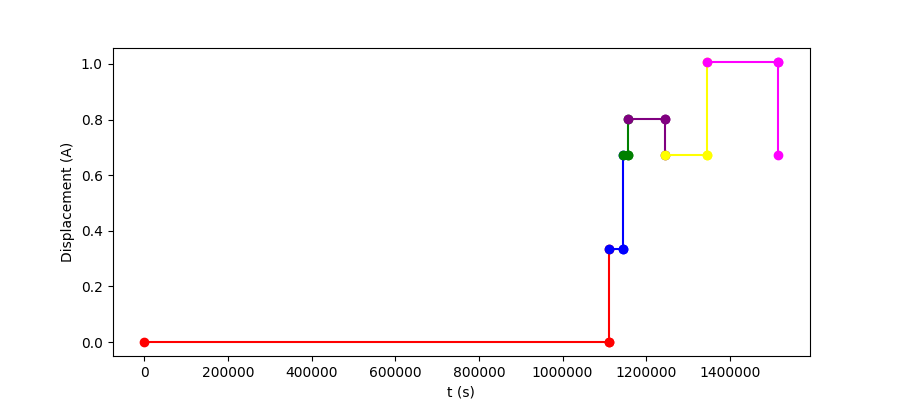

In [ ]:
# Your code here
